In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
#nltk.download('wordnet')
import gensim
import string
from wordcloud import WordCloud
from PIL import Image
import collections

[nltk_data] Downloading package wordnet to /home/quadm/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

def hasNumber(word):
    return any(char.isdigit() for char in word)
      
def preprocess(textfile):
    with open(textfile, 'r') as reader:
        text = reader.read()
    text = text.lower()     # Make all text lowercase
    nopunct="".join([char for char in text if char not in string.punctuation]) # Remove all punctuation
    tokens = nltk.tokenize.word_tokenize(nopunct) # Tokenize
    nonums = [t for t in tokens if not hasNumber(t)]  # Remove all numbers
    
    ps = PorterStemmer()
    
    nostop = [t for t in nonums if t not in nltk.corpus.stopwords.words('english')]
    return [ps.stem(t) for t in nostop]


In [73]:
import os
from tqdm  import tqdm

data = 'data'
train_corpus = []

for testTrain in ['C50test' , 'C50train']:
    for author in tqdm(os.listdir(os.path.join(data, testTrain))):
        for sample_text in os.listdir(os.path.join(data, testTrain, author)):
            train_corpus.append(preprocess(os.path.join(data, testTrain, author, sample_text)))

100%|██████████| 50/50 [02:17<00:00,  2.76s/it]


In [75]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=train_corpus, size=100, window=5, min_count=1, workers=4)
model.train([tokenized], total_examples=5000, epochs=100)
model.save('articles.model')

/home/quadm/anaconda3/lib/python3.8/site-packages/smart_open/smart_open_lib.py:400: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  warnings.warn(


In [76]:
vocab_list = sorted(list(model.wv.vocab.keys()))
word_vectors = []
for word in vocab_list:
    word_vectors.append(model.wv[word])

word_vectors = np.asarray(word_vectors)

In [77]:
norm_wv = word_vectors / np.linalg.norm(word_vectors)

In [78]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
transform = pca.fit_transform(norm_wv)

(30990, 1)
(30990, 1)


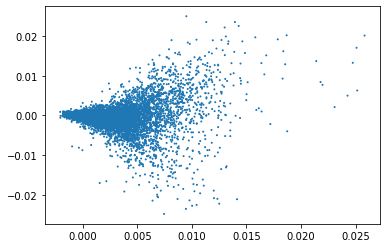

In [79]:
print(transform[:,:1].shape)
print(transform[:,1:2].shape)
plt.scatter(transform[:,:1], transform[:,1:2], s=[1]*transform.shape[0])

In [80]:
from sklearn.cluster import KMeans

sse = []
n_clusters = 1000
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(norm_wv)
sse.append(kmeans.inertia_)

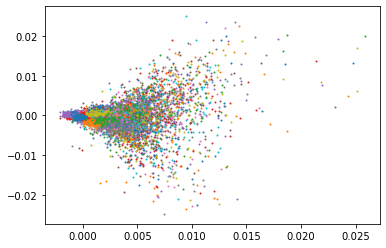

In [81]:
df = pd.DataFrame(transform)
df['Labels'] = kmeans.labels_
df.head()
group = df[df['Labels'] == 0]

for i in range(n_clusters):
    group = df[df['Labels'] == i]
    plt.scatter(group[0], group[1], s=1)

    

In [82]:
training_data = []
for corp in tqdm(train_corpus):
    n = np.zeros(n_clusters)
    for word in corp:
        i = vocab_list.index(word)
        l = int(df.loc[i]['Labels'])
        n[l] += 1
    training_data.append(n)
        

100%|██████████| 5000/5000 [25:29<00:00,  3.27it/s]


In [117]:
import sklearn
X = np.asarray(training_data)
for i in X:
    article = article / sum(article)
  
y_labels = range(50)
y_labels = list(np.repeat(y_labels, 50))*2
y_labels = np.asarray(y_labels)

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y_labels, test_size=0.2)

[ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  2.  1.  0.  3.
  2.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.  0.  0.  0.  0.  1.  0.  1.  1.
  0.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  5.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  2.  0.  0.
  0.  1.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.
  0.  0.  0.  0.  0.  1.  0.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0. 10.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  9.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  4. 16.  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.
  0.  0.  0.  1.  0.  1.  1.  1.  0.  0.  1.  0.  1.  0.  0.  2.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1

(4000, 1000)
